In [37]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, SpatialDropout1D



## 데이터 불러오기

In [38]:
# CSV 파일 불러오기
data = pd.read_csv('new_Hotel_reviews_20k.csv')
data.drop_duplicates(inplace=True)


# data = pd.read_csv('full_Hotel_reviews.csv',  encoding='latin-1')
# data = data[['rating_review','review_full']]
# data.drop_duplicates(inplace=True)


################ 데이터 샘플링 ############### 
################ 제외 가능 ################

# 각 클래스별 데이터 갯수 계산
class_counts = data['rating_review'].value_counts()

# 가장 적은 데이터 갯수를 가진 클래스의 갯수를 확인합니다
min_count = class_counts.min()

indices = []

for rating, count in class_counts.items():
    # 최소 데이터 갯수만큼 랜덤하게 인덱스를 추출합니다
    random_indices = np.random.choice(data[data['rating_review'] == rating].index, size=min_count, replace=False)
    indices.extend(random_indices)

# 추출한 인덱스를 사용하여 데이터를 선택합니다
data = data.loc[indices]





In [41]:
# 리뷰와 레이블 데이터 추출
# reviews = data['review_full'][::2]
# labels = data['rating_review'][::2]

reviews = data['review_full']
labels = data['rating_review']


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# 텍스트 데이터 전처리
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # 단어 토큰화
    words = word_tokenize(text)
    # 불용어 제거 및 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    # 리스트를 공백을 포함한 문자열로 변환
    processed_text = ' '.join(words)
    return processed_text

# 텍스트 정제 및 불용어 제거
reviews = reviews.apply(preprocess_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# # 데이터 정규화
# scaler = MinMaxScaler()
# padded_sequences = scaler.fit_transform(padded_sequences)


# 레이블 데이터 정규화
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

train_padded = padded_sequences[::2]
train_normalized_label = normalized_labels[::2]
test_padded = padded_sequences[1::2]
test_normalized_label = normalized_labels[1::2]
test_label = labels[1::2]

# LSTM 모델 구축
embedding_dim = 100
vocab_size = len(word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 훈련
history = model.fit(train_padded, train_normalized_label, epochs=10, batch_size=32, validation_split=0.2)


'''
Epoch 1/10
250/250 [==============================] - 136s 539ms/step - loss: 0.0726 - val_loss: 0.0407
Epoch 2/10
250/250 [==============================] - 136s 544ms/step - loss: 0.0257 - val_loss: 0.0402
Epoch 3/10
250/250 [==============================] - 134s 536ms/step - loss: 0.0148 - val_loss: 0.0433
Epoch 4/10
250/250 [==============================] - 135s 540ms/step - loss: 0.0097 - val_loss: 0.0438
Epoch 5/10
250/250 [==============================] - 136s 543ms/step - loss: 0.0069 - val_loss: 0.0449
Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 0.0051
'''

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/10
78/78 [==============================] - 21s 253ms/step - loss: 0.1027 - val_loss: 0.2692
Epoch 2/10
78/78 [==============================] - 19s 244ms/step - loss: 0.0354 - val_loss: 0.2064
Epoch 3/10
78/78 [==============================] - 19s 246ms/step - loss: 0.0233 - val_loss: 0.2500
Epoch 4/10
78/78 [==============================] - 19s 243ms/step - loss: 0.0174 - val_loss: 0.1787
Epoch 5/10
78/78 [==============================] - 19s 244ms/step - loss: 0.0133 - val_loss: 0.2085
Epoch 6/10
78/78 [==============================] - 19s 242ms/step - loss: 0.0122 - val_loss: 0.1824
Epoch 7/10
78/78 [==============================] - 19s 242ms/step - loss: 0.0112 - val_loss: 0.1876
Epoch 8/10
78/78 [==============================] - 19s 239ms/step - loss: 0.0097 - val_loss: 0.1789
Epoch 9/10
78/78 [==============================] - 19s 242ms/step - loss: 0.0086 - val_loss: 0.2123
Epoch 10/10
78/78 [==============================] - 19s 246ms/step - loss: 0.0083 - val_lo

'\nEpoch 1/10\n250/250 [==============================] - 136s 539ms/step - loss: 0.0726 - val_loss: 0.0407\nEpoch 2/10\n250/250 [==============================] - 136s 544ms/step - loss: 0.0257 - val_loss: 0.0402\nEpoch 3/10\n250/250 [==============================] - 134s 536ms/step - loss: 0.0148 - val_loss: 0.0433\nEpoch 4/10\n250/250 [==============================] - 135s 540ms/step - loss: 0.0097 - val_loss: 0.0438\nEpoch 5/10\n250/250 [==============================] - 136s 543ms/step - loss: 0.0069 - val_loss: 0.0449\nEpoch 6/10\n250/250 [==============================] - ETA: 0s - loss: 0.0051\n'

In [42]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 613, 100)          1671000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 613, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,713,305
Trainable params: 1,713,305
Non-trainable params: 0
____________________________________________

In [40]:
# 예측 결과 출력 (정수값)
predicted_ratings = model.predict(test_padded)

def convert_data(value):
    if value < 0.2:
        return 1
    elif value < 0.4:
        return 2
    elif value < 0.6:
        return 3
    elif value < 0.8:
        return 4
    else:
        return 5
    
predicted_ratings = list(map(lambda x: convert_data(float(x)), predicted_ratings))

from collections import Counter

print("예측 라벨 개수 : ", Counter(predicted_ratings))



# 반올림하여 정수로 출력
test_labels_list = test_label.tolist()  # Convert test_labels to a Python list
for i, rating in enumerate(predicted_ratings):
    print(f"Predicted rating for review {i+1}: {rating}")



# 모델 평가
loss = model.evaluate(test_padded, test_normalized_label)
print(f"Test Loss: {loss}")

98/98 [==============================] - 13s 126ms/step
예측 라벨 개수 :  Counter({3: 937, 4: 846, 2: 691, 5: 525, 1: 113})
Predicted rating for review 1: 4
Predicted rating for review 2: 5
Predicted rating for review 3: 3
Predicted rating for review 4: 4
Predicted rating for review 5: 5
Predicted rating for review 6: 4
Predicted rating for review 7: 4
Predicted rating for review 8: 3
Predicted rating for review 9: 5
Predicted rating for review 10: 5
Predicted rating for review 11: 5
Predicted rating for review 12: 4
Predicted rating for review 13: 5
Predicted rating for review 14: 5
Predicted rating for review 15: 5
Predicted rating for review 16: 5
Predicted rating for review 17: 4
Predicted rating for review 18: 5
Predicted rating for review 19: 5
Predicted rating for review 20: 4
Predicted rating for review 21: 4
Predicted rating for review 22: 4
Predicted rating for review 23: 3
Predicted rating for review 24: 5
Predicted rating for review 25: 5
Predicted rating for review 26: 5
Predict

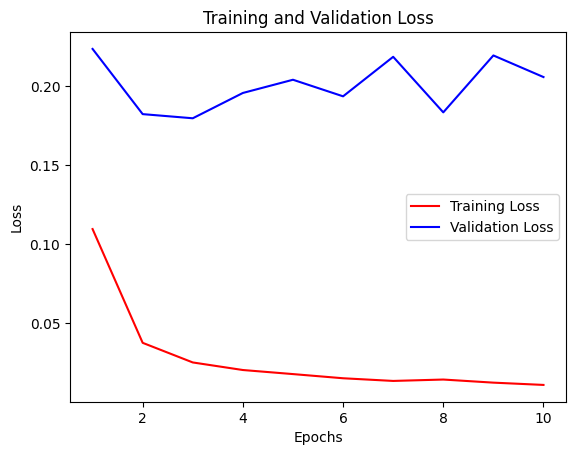

In [34]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실 값 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# epoch 수 추출
epochs = range(1, len(train_loss) + 1)

# 손실 값 시각화
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
